In [83]:
import os
import re
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences,find_peaks_cwt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sparta.Statistics as stat

In [2]:
delCep_results = []
alfUMi_results = []
RRLyr_results = []
SZCas_results = []
SZTau_results = []
TUCas_results = []
V1154_results = []
zetGem_results = []

for filename in os.listdir('./results_mixed/delCep/'):
    delCep_results.append(stat.open_csv('./results_mixed/delCep/'+filename))
for filename in os.listdir('./results_mixed/alfUMi/'):
    alfUMi_results.append(stat.open_csv('./results_mixed/alfUMi/'+filename))
for filename in os.listdir('./results_mixed/RRLyr/'):
    RRLyr_results.append(stat.open_csv('./results_mixed/RRLyr/'+filename))
for filename in os.listdir('./results_mixed/SZCas/'):
    SZCas_results.append(stat.open_csv('./results_mixed/SZCas/'+filename))
for filename in os.listdir('./results_mixed/SZTau/'):
    SZTau_results.append(stat.open_csv('./results_mixed/SZTau/'+filename))
for filename in os.listdir('./results_mixed/TUCas/'):
    TUCas_results.append(stat.open_csv('./results_mixed/TUCas/'+filename))
for filename in os.listdir('./results_mixed/V1154/'):
    V1154_results.append(stat.open_csv('./results_mixed/V1154/'+filename))
for filename in os.listdir('./results_mixed/zetGem/'):
    zetGem_results.append(stat.open_csv('./results_mixed/zetGem/'+filename))

In [3]:
plt.style.use('sparta')

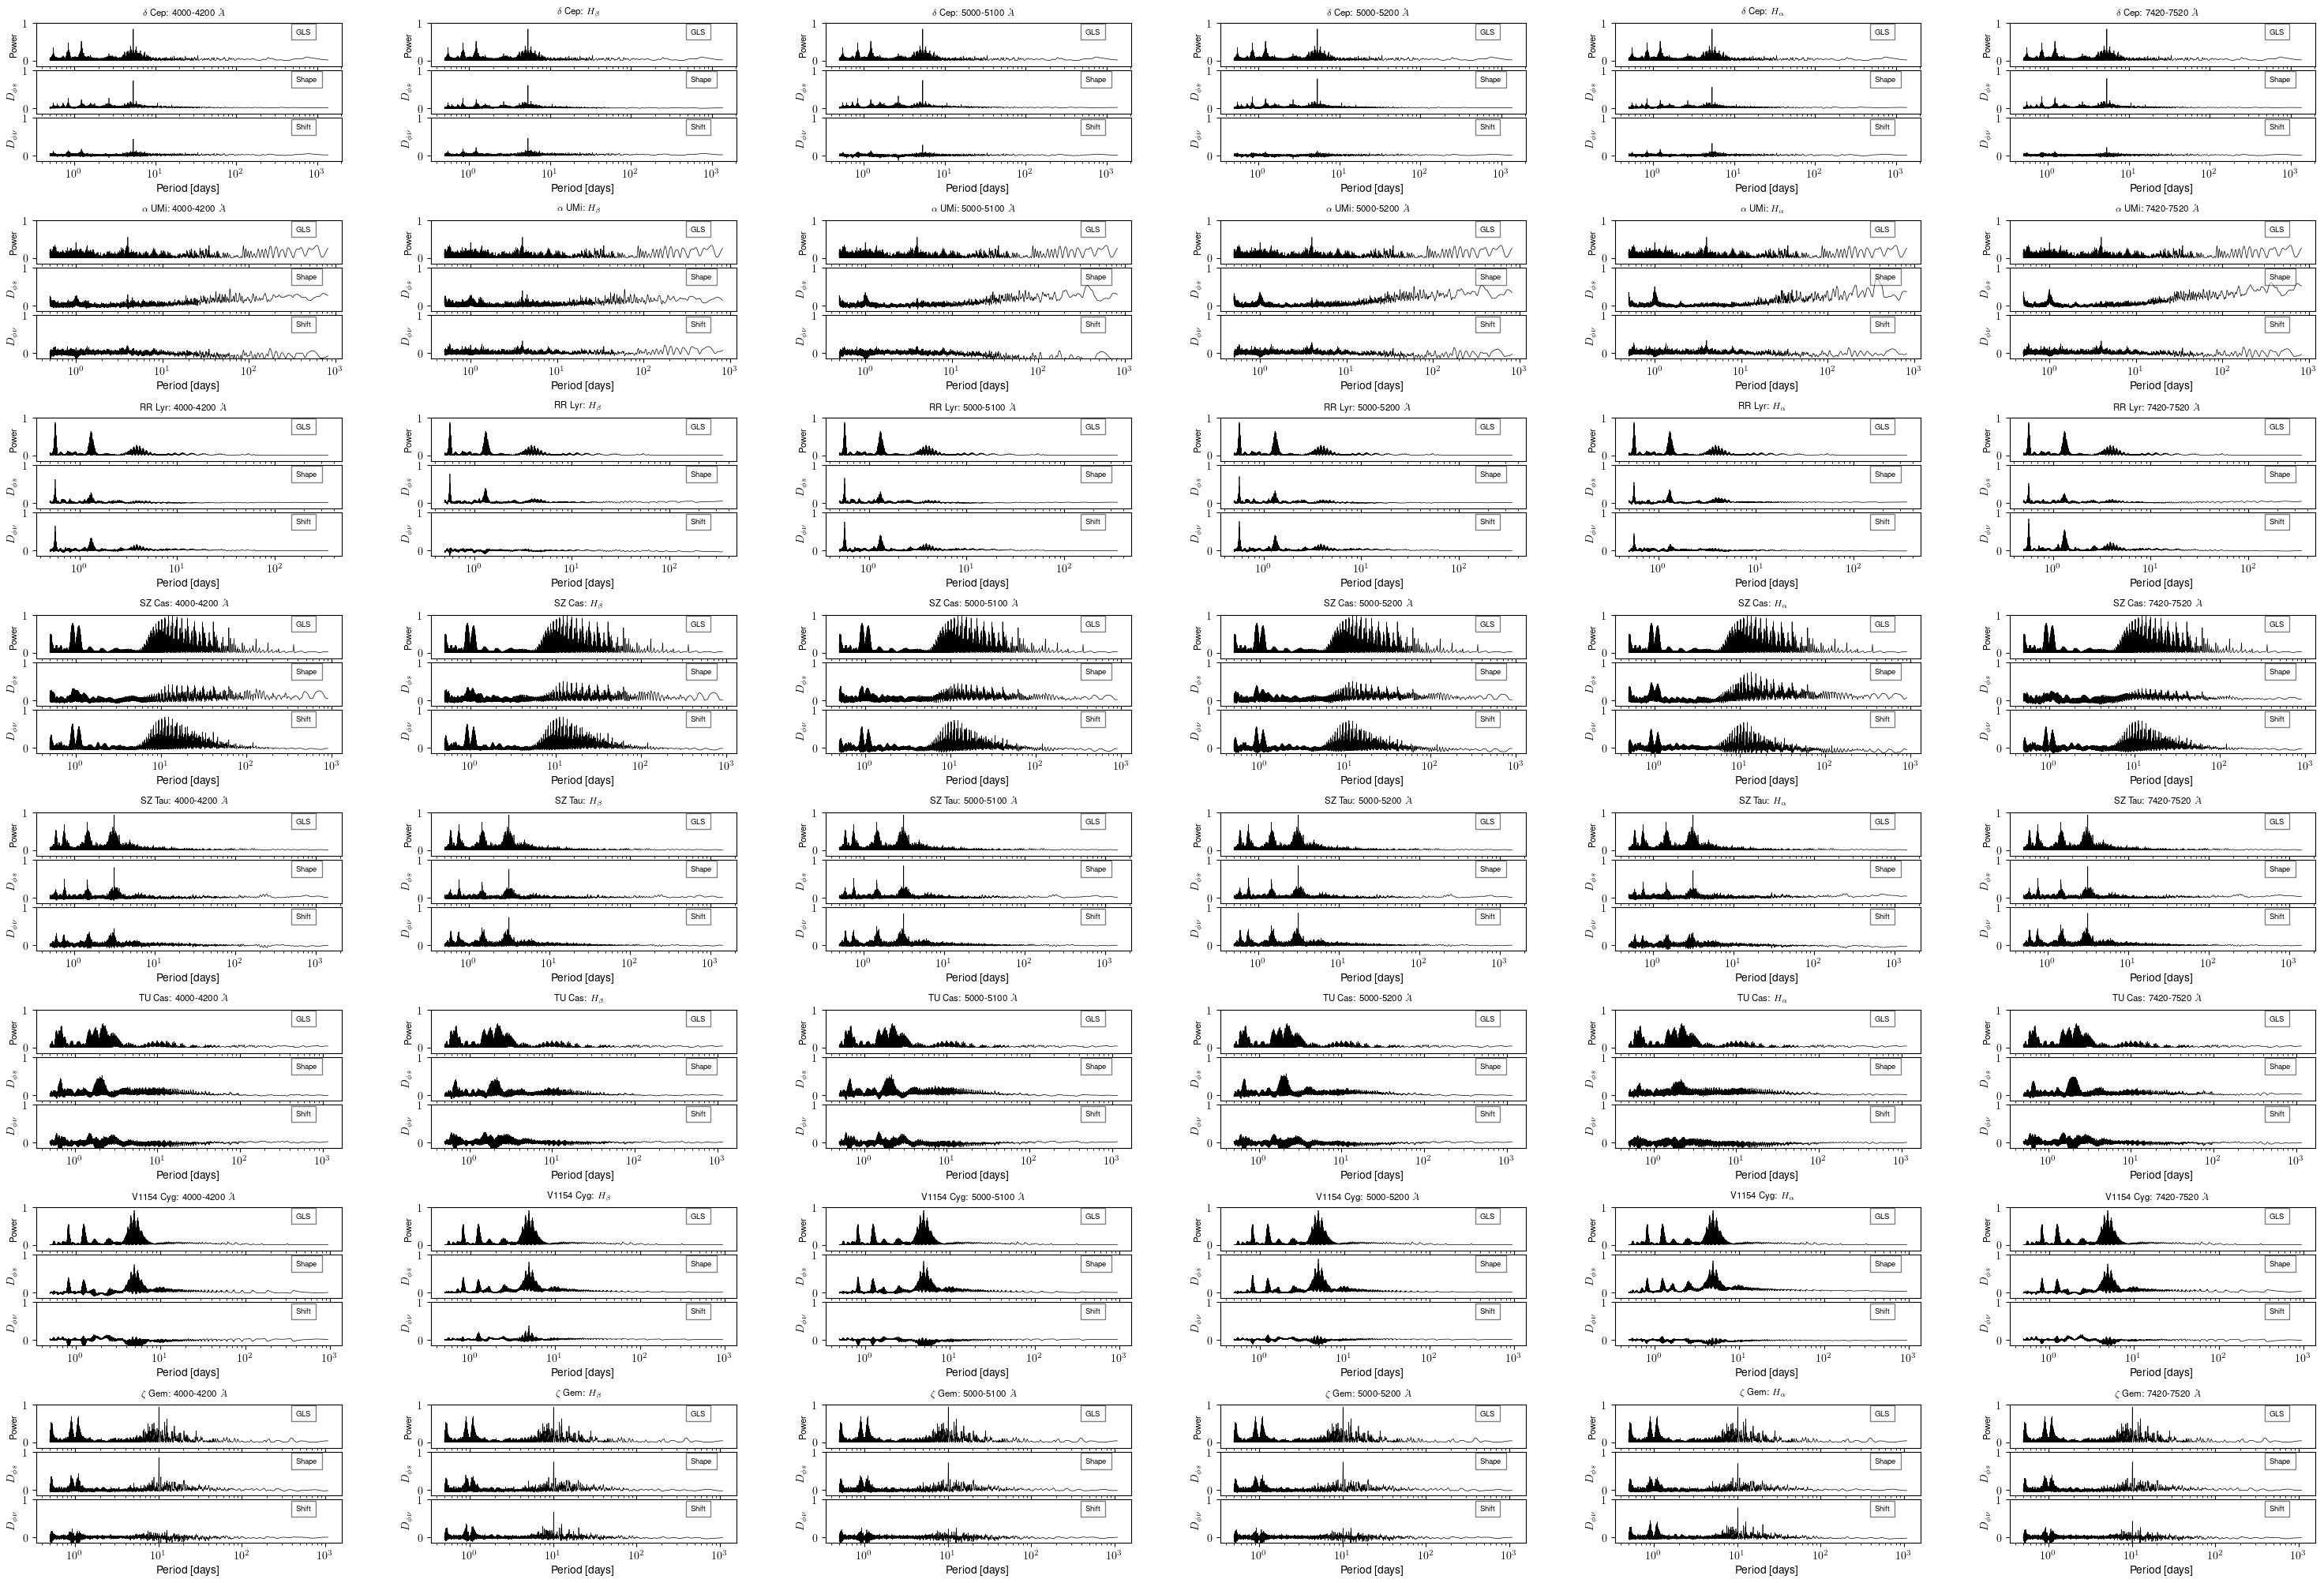

In [4]:
range_size = [r'4000-4200 $\AA$',r'$H_{\beta}$',r'5000-5100 $\AA$',r'5000-5200 $\AA$',r'$H_{\alpha}$',r'7420-7520 $\AA$']
all_results = [delCep_results,alfUMi_results,RRLyr_results,SZCas_results,SZTau_results,TUCas_results,V1154_results,zetGem_results]
fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'delcep')

subfigs = fig.subfigures(8, 6)
for outerind, subfig in enumerate(subfigs.flat):
    if 0<=outerind<=5:
        results = all_results[0]
        star = r'$\delta$ Cep'
    elif 6<=outerind<=11:
        results = all_results[1]
        star = r'$\alpha$ UMi'
    elif 12<=outerind<=17:
        results = all_results[2]
        star = r'RR Lyr'
    elif 18<=outerind<=23:
        results = all_results[3]
        star = r'SZ Cas'
    elif 24<=outerind<=29:
        results = all_results[4]
        star = r'SZ Tau'
    elif 30<=outerind<=35:
        results = all_results[5]
        star = r'TU Cas'
    elif 36<=outerind<=41:
        results = all_results[6]
        star = r'V1154 Cyg'
    elif 42<=outerind<=47:
        results = all_results[7]
        star = r'$\zeta$ Gem'
    axs = subfig.subplots(3,1,sharex=True,sharey = True)
    subfig.suptitle(star+': ' +str(range_size[outerind%6]), fontsize='small')
    for innerind, ax in enumerate(axs.flat):
        #put semilog(x)
        if innerind==0:
            ax.plot(results[outerind%6]['period'], results[outerind%6]['gls'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel('Power', fontsize='small')
        elif innerind==1:
            ax.plot(results[outerind%6]['period'], results[outerind%6]['shape'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi s}$')
        elif innerind==2:
            ax.plot(results[outerind%6]['period'],results[outerind%6]['shift'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi \nu}$')
            ax.set_xlabel(r'Period [days]')
        ax.set_ylim(-0.15,1)
        text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
        ax.text(0.85, 0.75, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),fontsize = 'x-small')
plt.subplots_adjust(top=0.9, hspace=0.1, wspace=0.2,bottom=0.2)
plt.savefig('all_Hermes.pdf')
plt.show()

### Finding the main peak and its harmonics

In [15]:
# loading times

delCep_times = pd.read_csv('./results_mixed/delCep/delCep_Hermes_spectra_times.csv').times.astype('float32')
alfUMi_times = pd.read_csv('./results_mixed/alfUMi/alfUMi_Hermes_spectra_times.csv').times.astype('float32')
RRLyr_times = pd.read_csv('./results_mixed/RRLyr/RRLyr_Hermes_spectra_times.csv').times.astype('float32')
SZCas_times = pd.read_csv('./results_mixed/SZCas/SZCas_Hermes_times.csv').times.astype('float32')
SZTau_times = pd.read_csv('./results_mixed/SZTau/SZTau_Hermes_times.csv').times.astype('float32')
TUCas_times = pd.read_csv('./results_mixed/TUCas/TUCas_Hermes_spectra_times.csv').times.astype('float32')
V1154_times = pd.read_csv('./results_mixed/V1154/V1154Cyg_Hermes_spectra_times.csv').times.astype('float32')
zetGem_times = pd.read_csv('./results_mixed/zetGem/zetGem_Hermes_spectra_times.csv').times.astype('float32')

times = [delCep_times,alfUMi_times,RRLyr_times,SZCas_times,SZTau_times,TUCas_times,V1154_times,zetGem_times]

In [111]:
pvalue = [1e-3]
p_value_levels = []
for idx, time in enumerate(times):
    pvalue_level = stat.calc_pdc_pval(time, pvalue, inverse_sf=True)
    p_value_levels.append(pvalue_level[0])

In [112]:
delCep_peaks = find_peaks(delCep_results[0]['shape'], height=pvalue_level[0],distance=5)

In [114]:
print(delCep_results[0]['period'][delCep_peaks[0]])

[5.36622989 2.68311495 1.22912098 0.84094372]


In [35]:
_,flat,power = stat.get_peaks(delCep_results[0]['period'],delCep_results[0]['shape'],threshold=0.1)

In [46]:
print(np.argsort(power))
#reaarrange the period and power
sorted_indices = np.argsort(power)
flat = list(flat)
sorted_flat = [flat[i] for i in sorted_indices]
print(sorted_flat)

[14 17 15  7 12  2 10  6  3 18  1  9  4 11 16  8  5  0 13]
[6.376226106452383, 5.967547127752361, 5.751263509822478, 2.800894165046565, 2.800894165046565, 2.4580763896372195, 2.4580763896372195, 1.7886848547717895, 2.575447022157414, 10.732459782395638, 1.587124640517196, 4.632448582670516, 0.5505513666670033, 4.952621435679406, 5.858349636169091, 1.229120975056693, 0.8409437235987182, 2.68311494559891, 5.36622989119782]
